In [141]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [142]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [143]:
train.shape, test.shape, submission.shape

((1205, 12), (50, 10), (50, 3))

In [144]:
train_target = train[['중식계', '석식계']]

### Feature

In [145]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

In [146]:
train['year'] = train['일자'].dt.year
test['year'] = test['일자'].dt.year

In [147]:
train['quarter'] = train['일자'].dt.quarter
test['quarter'] = test['일자'].dt.quarter

In [148]:
train['month'] = train['일자'].dt.month
test['month'] = test['일자'].dt.month

In [149]:
train['week'] = train['일자'].dt.week
test['week'] = test['일자'].dt.week

In [150]:
train['day'] = train['일자'].dt.day
test['day'] = test['일자'].dt.day

In [151]:
train['요일'] = train['일자'].dt.weekday
test['요일'] = test['일자'].dt.weekday

In [152]:
train['month_group'] = pd.cut(train['day'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

test['month_group'] = pd.cut(test['day'], bins = [1, 10, 20, 32], 
                              right = False, labels = ['Cho', 'Jung', 'Mal'])

In [153]:
train = pd.concat([train, pd.get_dummies(train['month_group'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['month_group'])], axis=1)

In [154]:
train['계절'] = train['month'].apply(lambda x : 'spring' if x in [3, 4, 5]
                                                  else 'summer' if x in [6, 7, 8]
                                                  else 'fall' if x in [9, 10, 11]
                                                  else 'winter')

test['계절'] = test['month'].apply(lambda x : 'spring' if x in [3, 4, 5]
                                                  else 'summer' if x in [6, 7, 8]
                                                  else 'fall' if x in [9, 10, 11]
                                                  else 'winter')

In [155]:
train['회사출근'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수'])
#train['휴가비율'] = train['본사휴가자수'] / train['본사정원수']
#train['출장비율'] = train['본사출장자수'] / train['본사정원수']
#train['야근비율'] = train['본사시간외근무명령서승인건수'] / train['회사출근']
#train['재택비율'] = train['현본사소속재택근무자수'] / train['본사정원수']
train['회사출근비율'] = train['회사출근'] / train['본사정원수']

In [156]:
test['회사출근'] = test['본사정원수'] - (test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수'])
#test['휴가비율'] = test['본사휴가자수'] / test['본사정원수']
#test['출장비율'] = test['본사출장자수'] / test['본사정원수']
#test['야근비율'] = test['본사시간외근무명령서승인건수'] / test['회사출근']
#test['재택비율'] = test['현본사소속재택근무자수'] / test['본사정원수']
test['회사출근비율'] = test['회사출근'] / test['본사정원수']

In [157]:
train['80%이상_출근'] = train['회사출근비율'].apply(lambda x : 1 if x>=0.80 else 0)
train['85%이상_출근'] = train['회사출근비율'].apply(lambda x : 1 if x>=0.85 else 0)
train['90%이상_출근'] = train['회사출근비율'].apply(lambda x : 1 if x>=0.90 else 0)

test['80%이상_출근'] = test['회사출근비율'].apply(lambda x : 1 if x>=0.80 else 0)
test['85%이상_출근'] = test['회사출근비율'].apply(lambda x : 1 if x>=0.85 else 0)
test['90%이상_출근'] = test['회사출근비율'].apply(lambda x : 1 if x>=0.90 else 0)

In [158]:
dow_chul = train.groupby('요일')['회사출근'].mean().reset_index()
dow_chul.columns = ['요일', 'dow_chulgun_mean']
train = train.merge(dow_chul, on='요일', how='left')

In [159]:
dow_chul = test.groupby('요일')['회사출근'].mean().reset_index()
dow_chul.columns = ['요일', 'dow_chulgun_mean']
test = test.merge(dow_chul, on='요일', how='left')

In [160]:
train['weekly_num'] = train['day'].apply(lambda x : 1 if (x>=1) and (x<=7)
                                                  else 2 if (x>7) and (x<=14)
                                                  else 3 if (x>14) and (x<=21)
                                                  else 4 if (x>21) and (x<=28) else 5)

test['weekly_num'] = test['day'].apply(lambda x : 1 if (x>=1) and (x<=7)
                                                  else 2 if (x>7) and (x<=14)
                                                  else 3 if (x>14) and (x<=21)
                                                  else 4 if (x>21) and (x<=28) else 5)    

In [161]:
wn_chul = train.groupby('weekly_num')['회사출근'].mean().reset_index()
wn_chul.columns = ['weekly_num', 'wn_chulgun_mean']
train = train.merge(wn_chul, on='weekly_num', how='left')

In [162]:
wn_chul = test.groupby('weekly_num')['회사출근'].mean().reset_index()
wn_chul.columns = ['weekly_num', 'wn_chulgun_mean']
test = test.merge(wn_chul, on='weekly_num', how='left')

In [163]:
train['회사출근_shift1'] = train['회사출근'].shift(1).fillna(train['회사출근'].mean())
test['회사출근_shift1'] = test['회사출근'].shift(1).fillna(test['회사출근'].mean())

train['회사출근_shift5'] = train['회사출근'].shift(5).fillna(train['회사출근'].mean())
test['회사출근_shift5'] = test['회사출근'].shift(5).fillna(test['회사출근'].mean())

In [164]:
train['야근_shift1'] = train['본사시간외근무명령서승인건수'].shift(1).fillna(train['본사시간외근무명령서승인건수'].mean())
test['야근_shift1'] = test['본사시간외근무명령서승인건수'].shift(1).fillna(test['본사시간외근무명령서승인건수'].mean())

train['야근_shift5'] = train['본사시간외근무명령서승인건수'].shift(5).fillna(train['본사시간외근무명령서승인건수'].mean())
test['야근_shift5'] = test['본사시간외근무명령서승인건수'].shift(5).fillna(test['본사시간외근무명령서승인건수'].mean())

In [165]:
train['lunch_length'] = train['중식메뉴'].apply(lambda x : len(x))
train['dinner_length'] = train['석식메뉴'].apply(lambda x : len(x))

test['lunch_length'] = test['중식메뉴'].apply(lambda x : len(x))
test['dinner_length'] = test['석식메뉴'].apply(lambda x : len(x))

In [166]:
### 연말 연초
train['월일'] = train['일자'].astype(str)
test['월일'] = test['일자'].astype(str)
train['월일'] = train['월일'].apply(lambda x : x[5:10])
test['월일'] = test['월일'].apply(lambda x : x[5:10])

In [167]:
def malcho(x):
    if (x[0:2] == '12' and int(x[3:5]) >= 20) or (x[0:2] == '01' and int(x[3:5]) <= 10):
        return 1
    else:
        return 0

In [168]:
train['연말연초'] = train['월일'].apply(malcho)
test['연말연초'] = test['월일'].apply(malcho)

In [169]:
def nextday_holiday(data) :
    nextday = []
    for i in range(len(data)-1) :
        try :
            if data['일자'][i] + datetime.timedelta(days=1) == data['일자'][i+1] :
                nextday.append(0)
            else :
                nextday.append(1)
        except ValueError :
            break
    nextday.append(0)
    data['다음날_휴일여부'] = nextday

In [170]:
def frontday_holiday(data) :
    holiday = []
    for i in range(1,len(data)) :
        if data['일자'][i] - datetime.timedelta(days=1) == data['일자'][i-1] :
            holiday.append(0)
        else:
            holiday.append(1)
    holiday.insert(0,0)
    data['전날_휴일여부'] = holiday

In [171]:
frontday_holiday(train)
nextday_holiday(train)

frontday_holiday(test)
nextday_holiday(test)

### menu

In [172]:
#### 띄어쓰기 및 오타 수정
train.at[1142, '중식메뉴'] = '쌀밥/곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D '
train['중식메뉴'] = train['중식메뉴'].str.replace('삽겹', '삼겹')

In [173]:
category = pd.read_excel('../input/대분류중분류.xlsx')

In [174]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        elif '/' in i:
            x_.extend(i.split('/'))
        elif '*' in i:
            x_.extend(i.split('*'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [175]:
train['조식메뉴_split'] = train['조식메뉴'].apply(lambda x: get_food_embedding(x))
train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['조식메뉴_split'] = test['조식메뉴'].apply(lambda x: get_food_embedding(x))
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [176]:
import re
regex = "\(.*\)|\s-\s.*"
category['소분류'] = category['소분류'].apply(lambda x : re.sub(regex, '', x))

In [177]:
밥_list = list(category[category['대분류'] == '밥류']['소분류'])
과자빵_list = list(category[category['대분류'] == '과자 및 빵류']['소분류'])
면만두_list = list(category[category['대분류'] == '면 및 만두류']['소분류'])
죽_list = list(category[category['대분류'] == '죽류']['소분류'])
국_list = list(category[category['대분류'] == '국(탕)류']['소분류'])
찌개_list = list(category[category['대분류'] == '찌개류']['소분류'])
찜_list = list(category[category['대분류'] == '찜류']['소분류'])
구이_list = list(category[category['대분류'] == '구이류']['소분류'])
전_list = list(category[category['대분류'] == '전류']['소분류'])
볶음_list = list(category[category['대분류'] == '볶음류']['소분류'])
조림_list = list(category[category['대분류'] == '조림류']['소분류'])
튀김_list = list(category[category['대분류'] == '튀김류']['소분류'])
무침_list = list(category[category['대분류'] == '무침류']['소분류'])
김치_list = list(category[category['대분류'] == '김치류']['소분류'])
회_list = list(category[category['대분류'] == '회류']['소분류'])
젓갈_list = list(category[category['대분류'] == '젓갈류']['소분류'])
절임_list = list(category[category['대분류'] == '절임류']['소분류'])
장_list = list(category[category['대분류'] == '장류']['소분류'])
우유_list = list(category[category['대분류'] == '우유 및 유제품류']['소분류'])
음료_list = list(category[category['대분류'] == '음료류']['소분류'])
떡_list = list(category[category['대분류'] == '떡류']['소분류'])
원재료_list = list(category[category['대분류'] == '원재료']['소분류'])
주류_list = list(category[category['대분류'] == '주류']['소분류'])

In [178]:
num=[]
for t in range(train.shape[0]):
    for i in range(len(train['중식메뉴_split'][t])):
        token = train['중식메뉴_split'][t][i]
        if  token.endswith('주') or token in 주류_list:
            print(token)
            num.append(token)

In [179]:
num=pd.DataFrame(num)
num=pd.DataFrame(num.value_counts().index.values)
num=pd.DataFrame(num[0].apply(lambda x: x[0]))

In [180]:
def get_Dae(data, col) :
    
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 25)), 
                          columns = ['밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류',
       '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류',
       '우유 및 유제품류', '음료류', '떡류', '원재료', '주류', '드레싱류', '조리_기타'])

    for t in range(data.shape[0]):
        for i in range(len(data[col][t])):
            token = data[col][t][i]
            if '덮밥' in token or '비빔밥' in token or '볶음밥' in token:
                recipe_df.at[t,'밥류'] +=3
            elif  token.endswith('밥') or '밥' in token or token in 밥_list:
                recipe_df.at[t, '밥류'] += 1 
                
            elif token.endswith('과자') or token in 과자빵_list:
                recipe_df.at[t, '과자 및 빵류'] += 3
                
            elif token.endswith('면') or token.endswith('만두') or '면' in token or '만두' in token or token in 면만두_list:
                recipe_df.at[t, '면 및 만두류'] += 4
                
            elif token.endswith('죽') or token in 죽_list or '죽' in token:
                recipe_df.at[t, '죽류'] += 2
                
            elif token.endswith('구이') or token in 구이_list or '구이' in token or token.endswith('데리야끼') or token.endswith('립') or\
                '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token:
                recipe_df.at[t, '구이류'] += 5
                
            elif token.endswith('국') or token.endswith('탕') or token in 국_list:
                if '만두' in token or '해물' in token or '도토리묵' in token or '냉국' in token or '사골' in token or '고기' in token or '해장' in token or token=='육개장'  or '수제비' in token or '옹심이' in token or '삼계탕' in token or '닭볶' in token or '전복' in token or '나주곰탕' in token or '감자탕' in token or '갈비' in token or '등뼈탕' in token or '들깨' in token or '홍합' in token or '새우' in token:
                    recipe_df.at[t, '국(탕)류'] += 4
                else:
                    recipe_df.at[t, '국(탕)류'] += 2
                    
            elif token.endswith('찌개') or token in 찌개_list:
                if '차돌' in token or '갈비' in token or '고기' in token or '돼지' in token: 
                    recipe_df.at[t, '찌개류'] += 4
                else:
                    recipe_df.at[t, '찌개류'] += 2
                
            elif token.endswith('찜') or token in 찜_list or '찜' in token or '보쌈' in token or '수육' in token or '김치말이' in token:
                if '브로컬리들깨찜' in token or  '꽈리고추찜' in token or  '깻잎찜' in token or  '가지찜' in token or  '청경채찜' in token or '호박잎쌈' in token:
                    recipe_df.at[t, '찜류'] += 2
                else:
                    recipe_df.at[t, '찜류'] += 4
                
            elif token.endswith('전') or token in 전_list or '전병' in token:
                recipe_df.at[t, '전류'] += 3
                
            elif token.endswith('볶음') or token in 볶음_list or '볶음' in token or token == '깐풍연근' or \
                '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token:
                if '미역줄기볶음' in token or '마늘쫑볶음' in token or '카레감자채볶음' in token or '모둠버섯볶음' in token or '고구마순볶음' in token or '콩나물볶음' in token or '버섯볶음' in token or '멸치' in token or '가지볶음' in token or '애기새송이버섯볶음' in token or '파프리카감자채볶음' in token or '호박새우젓볶음' in token or '청경채새송이볶음' in token or '오이볶음' in token or '호박채나물볶음' in token or '도라지볶음' in token or '도라지나물볶음' in token or '고춧잎볶음' in token or '고구마줄기볶음' in token or '감자볶음' in token or '새송이버섯볶음' in token or '가지볶음' in token or '브로콜리버섯볶음' in token or '명엽채볶음' in token or '매운호박볶음' in token or '머위대들깨볶음' in token or '멸치볶음' in token:
                    recipe_df.at[t, '볶음류'] += 1
                else:
                    recipe_df.at[t, '볶음류'] += 3
                
            elif token.endswith('조림') or token in 조림_list or '조림' in token or '오향장육' in token or '동파육' in token:
                if '땅콩조림' in token or '연근조림' in token or '견과류조림' in token or '연근땅콩조림' in token or '새송이버섯조림' in token or '우엉조림' in token or '시래기조림' in token or '검정콩조림' in token or '꽈리고추어묵조림' in token or '단호박장조림' in token or '감자조림' in token or '견과류연근조림' in token or '고추장감자조림' in token or '꽈리고추감자조림' in token or '콩조림' in token:
                    recipe_df.at[t, '조림류'] += 1
                else:
                    recipe_df.at[t, '조림류'] += 3
            elif token.endswith('튀김') or token.endswith('치킨') or token.endswith('탕수육') or '치킨' in token or '탕수' in token or token in 튀김_list or\
                '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or\
                token.endswith('고로케') or '유린기' in token or '탕수' in token or token.endswith('닭') or '너겟' in token or\
                token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token:
                recipe_df.at[t, '튀김류'] += 5
                
            elif token.endswith('무침') or token in 무침_list or '무침' in token or '파채' in token or token.endswith('샐러드') or '양장피' in token\
            or '범벅' in token or token.endswith('채'):
                recipe_df.at[t, '무침류'] += 1
                
            elif token.endswith('김치') or token in 김치_list or '겉절이' in token:
                recipe_df.at[t, '김치류'] += 1
                
            elif token.endswith('회') or token in 회_list:
                recipe_df.at[t, '회류'] += 1
                
            elif token.endswith('젓갈') or token in 젓갈_list or '젓갈' in token:
                recipe_df.at[t, '젓갈류'] += 1
                
            elif token.endswith('절임') or token in 절임_list or '절임' in token:
                recipe_df.at[t, '절임류'] += 1
                
            elif token.endswith('장') or token in 장_list:
                recipe_df.at[t, '장류'] += 1
                
            elif token.endswith('우유') or token in 우유_list:
                recipe_df.at[t, '우유 및 유제품류'] += 1
                
            elif token.endswith('음료') or token in 음료_list or '요구르트' in token:
                recipe_df.at[t, '음료류'] += 1
                
            elif token.endswith('떡') or token in 떡_list:
                recipe_df.at[t, '떡류'] += 2
                
            elif token in 원재료_list or token == '연두부' or token.endswith('김') or '생' in token or token.endswith('쌈'):
                recipe_df.at[t, '원재료'] += 1
                
            elif token.endswith('주') or token in 주류_list:
                recipe_df.at[t, '주류'] += 1
                
            elif token.endswith('드레싱') or 'D' in token or '소스' in token:
                recipe_df.at[t, '드레싱류'] += 1
                
            else :
                recipe_df.at[t, '조리_기타'] += 1
            
    return recipe_df

In [181]:
tr_morning = get_Dae(train, '조식메뉴_split')
tr_lunch = get_Dae(train, '중식메뉴_split')
tr_dinner = get_Dae(train, '석식메뉴_split')

ts_morning = get_Dae(test, '조식메뉴_split')
ts_lunch = get_Dae(test, '중식메뉴_split')
ts_dinner = get_Dae(test, '석식메뉴_split')

In [182]:
tr_lunch.shape, tr_dinner.shape, ts_lunch.shape, ts_dinner.shape

((1205, 25), (1205, 25), (50, 25), (50, 25))

In [183]:
tr_sum = tr_lunch + tr_dinner
ts_sum = ts_lunch + ts_dinner

In [184]:
tr_sum1 = tr_sum.copy()
for i in range(tr_sum.shape[0]):
    for j in range(tr_sum.shape[1]):
        if tr_sum.iloc[i, j] >= 5:
            tr_sum1.iloc[i, j] = 2
        elif tr_sum.iloc[i, j] >=3:
            tr_sum1.iloc[i, j] = 1
        else:
            tr_sum1.iloc[i, j] = 0

In [185]:
ts_sum1 = ts_sum.copy()
for i in range(ts_sum.shape[0]):
    for j in range(ts_sum.shape[1]):
        if ts_sum.iloc[i, j] >= 5:
            ts_sum1.iloc[i, j] = 2
        elif ts_sum.iloc[i, j] >=3:
            ts_sum1.iloc[i, j] = 1
        else:
            ts_sum1.iloc[i, j] = 0

In [186]:
train['점저유사도'] = tr_sum1.sum(axis=1).astype(int)
test['점저유사도'] = ts_sum1.sum(axis=1).astype(int)

In [187]:
#train_ln = pd.concat([train, tr_lunch], axis=1)
#train_dn = pd.concat([train, tr_dinner], axis=1)
#test_ln = pd.concat([test, ts_lunch], axis=1)
#test_dn = pd.concat([test, ts_dinner], axis=1)

In [188]:
#train_ln.shape, train_dn.shape, test_ln.shape, test_dn.shape

In [189]:
train['lunch_score'] = tr_lunch.sum(axis=1)
train['dinner_score'] = tr_dinner.sum(axis=1)
test['lunch_score'] = ts_lunch.sum(axis=1)
test['dinner_score'] = ts_dinner.sum(axis=1)

### modeling

In [190]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostRegressor, Pool
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

In [191]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

In [192]:
select_columns_ln=test.columns[(test.dtypes== 'int64') + (test.dtypes== 'float64')+ (test.dtypes== 'uint8')]
select_columns_dn=test.columns[(test.dtypes== 'int64') + (test.dtypes== 'float64')+ (test.dtypes== 'uint8')]

In [193]:
select_columns_ln=select_columns_ln.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수'])
select_columns_dn=select_columns_dn.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수'])

In [194]:
X1 = train[select_columns_ln]
y1 = train.중식계
target1 = test[X1.columns]
X1 = X1.fillna(0)
target1 = target1.fillna(0)

In [195]:
X2 = train[select_columns_dn]
y2 = train.석식계
target2 = test[X2.columns]
X2 = X2.fillna(0)
target2 = target2.fillna(0)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:36<00:00,  2.64it/s]

(86, -89.44183427302605)


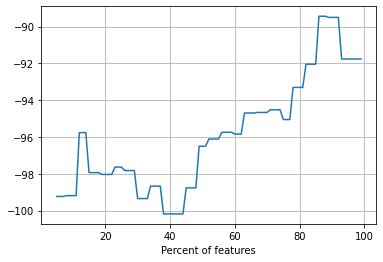

In [197]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X1, y1)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y1, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [198]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs1 = SelectPercentile(percentile=best_score[0]).fit(X1, y1)
X1_select = fs1.transform(X1)
target1_select = fs1.transform(target1)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:39<00:00,  2.38it/s]

(97, -63.922901788692606)


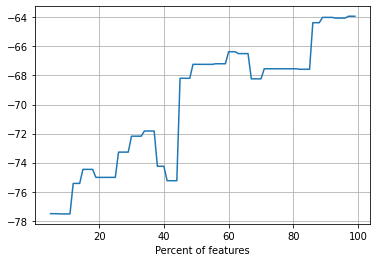

In [199]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X2, y2)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y2, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [200]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs2 = SelectPercentile(percentile=best_score[0]).fit(X2, y2)
X2_select = fs2.transform(X2)
target2_select = fs2.transform(target2)

In [201]:
print(X1_select.shape)
print(X1.columns[fs1.get_support()].tolist()) 
# get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 24)
['요일', 'year', 'quarter', 'week', 'day', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', 'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', 'lunch_score']


In [202]:
print(X2_select.shape)
print(X2.columns[fs2.get_support()].tolist()) 

(1205, 27)
['요일', 'year', 'quarter', 'month', 'week', 'day', 'Cho', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', 'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', 'dinner_score']


In [254]:
X1 = train[['요일', 'year', 'quarter', 'week', 'day', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', \
            'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', 'lunch_score']]
target1 = test[X1.columns]

In [255]:
X2 = train[['요일', 'year', 'quarter', 'month', 'week', 'day', 'Cho', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', \
            'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', \
            'dinner_score']]
y2 = train.석식계
target2 = test[X2.columns]

In [256]:
X1.to_csv('../input/x1.csv')
X2.to_csv('../input/x2.csv')

target1.to_csv('../input/target1.csv')
target2.to_csv('../input/target2.csv')

In [205]:
X1 = X1.astype(int)
X2 = X2.astype(int)
target1 = target1.astype(int)
target2 = target2.astype(int)

In [206]:
cat_features_ln = ['요일', 'year', 'quarter', 'week', 'day', 'Jung', 'Mal', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'weekly_num', '연말연초', '전날_휴일여부', '다음날_휴일여부']
                  
cat_features_dn = ['요일', 'year', 'quarter', 'month', 'week', 'day', 'Cho', 'Jung', 'Mal', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'weekly_num', '연말연초', '전날_휴일여부', \
                   '다음날_휴일여부']

In [207]:
cb = CatBoostRegressor(iterations = 20000, learning_rate = 0.01, eval_metric = 'MAE', silent = True, 
                       loss_function = 'MAE')

In [208]:
cb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y, cat_features = cat_features_ln)
    val_data = Pool(data = val_x, label = val_y, cat_features = cat_features_ln)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target1, ntree_end = best) / 15
    cb_pred_1 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 166.6809243	test: 162.9896286	best: 162.9896286 (0)	total: 135ms	remaining: 44m 53s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 66.93070711
bestIteration = 1544

Shrink model to first 1545 iterations.
FOLD MAE = 66.94211419569555
0:	learn: 168.5909955	test: 136.1030854	best: 136.1030854 (0)	total: 14.2ms	remaining: 4m 44s
5000:	learn: 26.5289782	test: 65.1444850	best: 65.1274194 (4917)	total: 1m 25s	remaining: 4m 17s
10000:	learn: 18.4464861	test: 64.5500371	best: 64.5397897 (9981)	total: 2m 55s	remaining: 2m 55s
15000:	learn: 14.6578755	test: 64.2184399	best: 64.1261463 (14543)	total: 4m 26s	remaining: 1m 28s
19999:	learn: 12.3260927	test: 63.8490172	best: 63.8490172 (19999)	total: 5m 55s	remaining: 0us

bestTest = 63.84901722
bestIteration = 19999

FOLD MAE = 63.849037142803155
0:	learn: 164.6012624	test: 192.0414805	best: 192.0414805 (0)	total: 5.61ms	remaining: 1m 52s
5000:	learn: 27.0072127	test: 90.4718050	best: 90.4168492 (4856)	total: 1m 27s	re

In [209]:
cb_pred_1

array([ 919.25151118,  857.93502697,  669.23096428, 1170.50308334,
        994.77261409,  962.5292022 ,  936.43070213,  737.45427113,
       1133.04358927,  997.13460567,  841.05901807, 1117.79066637,
       1029.87796132, 1032.09191352,  905.42094884,  754.52913889,
       1132.44974599, 1005.94970151,  997.53282729,  886.82685365,
        729.09876016, 1088.89069223,  986.93572568,  899.35107126,
        794.99387691, 1137.94367913, 1016.64146803, 1021.39282081,
        879.80284407,  722.7981749 , 1162.48293546, 1046.2853879 ,
        986.76676491,  894.18668413,  703.44972182, 1161.62500436,
        988.57909222,  987.65642122,  875.31207636,  679.11081291,
       1130.30868857,  973.29144495,  975.25822158,  820.48046082,
        652.20012245, 1099.64602272,  924.26901474,  907.73213335,
        800.21170019,  728.98018036])

In [210]:
cb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    train_data = Pool(data = tr_x, label = tr_y, cat_features = cat_features_dn)
    val_data = Pool(data = val_x, label = val_y, cat_features = cat_features_dn)
    cb.fit(train_data, eval_set = val_data, early_stopping_rounds = 2000, use_best_model = True, verbose = 5000)
    best = cb.best_iteration_
    pred = cb.predict(val_x, ntree_end = best)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = cb.predict(target2, ntree_end = best) / 15
    cb_pred_2 += sub_pred
print(f'\n{cb.__class__.__name__} MAE = {np.mean(mae_list)}')

0:	learn: 97.4875880	test: 100.7786410	best: 100.7786410 (0)	total: 43.4ms	remaining: 14m 28s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 57.50085577
bestIteration = 2185

Shrink model to first 2186 iterations.
FOLD MAE = 57.5244297809956
0:	learn: 97.8203994	test: 98.8667891	best: 98.8667891 (0)	total: 16.5ms	remaining: 5m 30s
5000:	learn: 17.8533153	test: 58.1694286	best: 58.1309428 (4929)	total: 1m 33s	remaining: 4m 41s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 57.97470996
bestIteration = 7484

Shrink model to first 7485 iterations.
FOLD MAE = 57.97543136896629
0:	learn: 97.2959332	test: 104.1195052	best: 104.1195052 (0)	total: 16.9ms	remaining: 5m 37s
5000:	learn: 18.2373766	test: 55.8808722	best: 55.8410039 (4672)	total: 1m 33s	remaining: 4m 41s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 55.50056771
bestIteration = 7919

Shrink model to first 7920 iterations.
FOLD MAE = 55.505543865340755
0:	learn: 97.50024

In [211]:
cb_pred_2

array([368.58867846, 355.11684415, 280.09985238, 531.45936312,
       497.19362501, 378.024407  , 468.12050403, 321.37619771,
       476.37515411, 479.53517306, 273.08268587, 540.22155427,
       499.3915647 , 447.43826201, 453.20050836, 335.7583254 ,
       500.08043145, 533.52900175, 350.72517403, 440.32805772,
       339.11813935, 530.98691351, 435.72402607, 399.69601085,
       394.09178934, 516.88396507, 595.41074843, 395.33511924,
       494.35676914, 302.4630303 , 539.36796181, 578.22409597,
       371.88695646, 470.20171568, 277.72294587, 544.44725169,
       518.68188919, 383.11482695, 431.25364902, 323.27274709,
       562.09917047, 527.34563059, 345.66907414, 427.56286941,
       280.19351492, 496.80081766, 493.07069767, 348.7449958 ,
       421.2477771 , 337.20823615])

In [212]:
X1 = train[['요일', 'year', 'quarter', 'week', 'day', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', \
            'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', 'lunch_score']]
target1 = test[X1.columns]

In [213]:
X2 = train[['요일', 'year', 'quarter', 'month', 'week', 'day', 'Cho', 'Jung', 'Mal', '회사출근', '회사출근비율', '80%이상_출근', '85%이상_출근', '90%이상_출근', 'dow_chulgun_mean', \
            'weekly_num', 'wn_chulgun_mean', '회사출근_shift1', '회사출근_shift5', '야근_shift1', '야근_shift5', 'lunch_length', 'dinner_length', '연말연초', '전날_휴일여부', '다음날_휴일여부', \
            'dinner_score']]
y2 = train.석식계
target2 = test[X2.columns]

In [214]:
ngb = NGBRegressor(n_estimators = 20000, verbose = 0, random_state = 607)

In [215]:
ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 69.03205327859484
FOLD MAE = 43.06773114860737
FOLD MAE = 43.54401496328001
FOLD MAE = 34.95588770217841
FOLD MAE = 37.334892073953384
FOLD MAE = 36.31457378284456
FOLD MAE = 28.116759266005754
FOLD MAE = 28.03442610881322
FOLD MAE = 23.07404784510502
FOLD MAE = 25.918165446690388
FOLD MAE = 26.783588664477442
FOLD MAE = 23.747681446171065
FOLD MAE = 22.346794479320558
FOLD MAE = 25.847484884476604
FOLD MAE = 25.78578300371538

NGBRegressor MAE = 32.926925606282275


In [216]:
ngb_pred_1

array([ 892.14304057,  888.36191476,  595.94780788, 1322.40166912,
       1122.8169925 , 1068.38111848, 1068.89661174,  821.62729109,
       1265.94212218, 1106.29211871,  999.14099311, 1188.05109989,
       1087.26124365, 1143.51036693,  986.32521912,  818.0085462 ,
       1151.33628135, 1045.0856349 , 1026.04318298,  936.28267099,
        730.09836219, 1310.07941246, 1122.22939924, 1018.4749922 ,
        965.95817261, 1207.30480241, 1112.24564006, 1112.01346351,
        937.83664306,  766.17219088, 1276.60663881, 1152.62430827,
       1062.13524101,  902.97280798,  686.49692759, 1190.08595255,
       1036.43267632, 1018.66188686,  882.5151391 ,  601.15908248,
       1097.59901865,  950.7677613 ,  971.36969259,  909.71522267,
        666.12473514, 1235.7149477 , 1002.82725573,  969.72512013,
        870.45392548,  786.19943589])

In [217]:
ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 58.863003074523476
FOLD MAE = 38.4536825515627
FOLD MAE = 23.966037992433023
FOLD MAE = 25.255650686238187
FOLD MAE = 17.936823787391063
FOLD MAE = 20.8082450767423
FOLD MAE = 20.788358838276668
FOLD MAE = 17.146084547332425
FOLD MAE = 15.672220501180727
FOLD MAE = 14.884657338100505
FOLD MAE = 16.28209202349997
FOLD MAE = 12.843794644386781
FOLD MAE = 11.546264079091024
FOLD MAE = 12.344335225338218
FOLD MAE = 11.97962040690995

NGBRegressor MAE = 21.251391384867134


In [218]:
ngb_pred_2

array([517.93571113, 405.61823901, 344.1633838 , 512.4286874 ,
       430.50289847, 408.20507199, 477.95585489, 399.93570499,
       522.57854343, 508.72336394, 363.91624815, 610.37175685,
       598.65599339, 478.80684622, 514.49587204, 388.51995855,
       727.1988018 , 798.58232582, 528.86031298, 630.98326832,
       469.87469805, 608.30133049, 540.34931167, 607.95113709,
       483.10870708, 591.03116243, 756.25723089, 634.97789681,
       576.07205403, 462.22307684, 697.89561691, 704.77802478,
       485.36103278, 521.89441351, 393.90766346, 728.90028423,
       717.06882342, 533.1351831 , 598.77103591, 320.95270415,
       724.42601688, 725.90702773, 439.18743308, 470.48569902,
       284.6880385 , 516.41676524, 509.52786338, 359.82407569,
       477.23331501, 385.80313168])

In [219]:
lgbm = LGBMRegressor(random_state = 607, max_depth = 8, n_estimators = 20000, learning_rate = .01)

In [220]:
X1 = X1.values
X2 = X2.values

In [221]:
lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1[tr_idx], X1[val_idx]
    tr_y, val_y = y1[tr_idx], y1[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 20.6704	training's l2: 748.239	valid_1's l1: 63.3486	valid_1's l2: 7427.79
Early stopping, best iteration is:
[294]	training's l1: 54.5096	training's l2: 5232.6	valid_1's l1: 59.0126	valid_1's l2: 6384.34
FOLD MAE = 59.01255747859167
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 21.2435	training's l2: 773.778	valid_1's l1: 64.5469	valid_1's l2: 7004.47
Early stopping, best iteration is:
[1117]	training's l1: 31.0011	training's l2: 1648.91	valid_1's l1: 64.0285	valid_1's l2: 6825.47
FOLD MAE = 64.02845010704328
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 19.7751	training's l2: 707.976	valid_1's l1: 90.0469	valid_1's l2: 13487.8
Early stopping, best iteration is:
[1347]	training's l1: 27.1139	training's l2: 1315.54	valid_1's l1: 90.3573	valid_1's l2: 13439.1
FOLD MAE = 90.35728716167921
Training until validation scores don't 

In [222]:
lgbm_pred_1

array([ 918.20717639,  907.39289421,  648.08188845, 1232.63158164,
       1037.33071991,  981.9895407 ,  980.2782133 ,  753.22031749,
       1219.45974915, 1070.97763463,  829.42472943, 1242.41435582,
       1101.32718153, 1112.57428623,  982.3421888 ,  788.0006653 ,
       1178.990098  , 1088.08033378, 1055.72890587,  951.30339602,
        732.97118093, 1153.01261444, 1034.76574879,  944.00981827,
        779.89387447, 1237.68731938, 1010.34938533, 1016.89471689,
        963.90993504,  706.62844437, 1244.42234668, 1107.28757515,
       1059.89764128,  970.12017899,  678.74089315, 1227.21849871,
       1079.51611081, 1042.57723863,  920.38359806,  622.95060848,
       1181.20911365, 1031.47305725, 1008.40195712,  858.57432767,
        637.47811573, 1214.23545629,  983.88176913,  962.55052331,
        846.17766536,  794.47853996])

In [223]:
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2[tr_idx], X2[val_idx]
    tr_y, val_y = y2[tr_idx], y2[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 14.3795	training's l2: 392.673	valid_1's l1: 57.1035	valid_1's l2: 6237.01
Early stopping, best iteration is:
[1235]	training's l1: 20.5537	training's l2: 811.755	valid_1's l1: 56.5818	valid_1's l2: 6062.01
FOLD MAE = 56.58176350226551
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 14.6346	training's l2: 364.648	valid_1's l1: 54.2642	valid_1's l2: 7821.57
Early stopping, best iteration is:
[684]	training's l1: 27.8145	training's l2: 1402.45	valid_1's l1: 53.864	valid_1's l2: 7751.27
FOLD MAE = 53.864036486375376
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 14.0575	training's l2: 374.33	valid_1's l1: 55.8096	valid_1's l2: 5853.91
Early stopping, best iteration is:
[1087]	training's l1: 22.2377	training's l2: 935.589	valid_1's l1: 55.606	valid_1's l2: 5694.73
FOLD MAE = 55.60603865142648
Training until validation scores don't i

In [224]:
lgbm_pred_2

array([395.60460134, 386.67851921, 273.09250913, 480.47107603,
       444.86906491, 385.91349386, 434.21456123, 312.22137483,
       473.18481468, 447.52207107, 273.63997262, 548.14247911,
       542.18760145, 578.10227539, 531.08190166, 353.46854345,
       542.77856621, 603.88774768, 426.82106516, 510.45814348,
       332.5734168 , 572.81651358, 498.26157194, 420.22764937,
       424.25648182, 550.38599832, 561.65409358, 460.28926961,
       504.57718875, 333.49489137, 592.09450448, 588.18449828,
       427.57889968, 542.26732947, 297.82626767, 600.5145687 ,
       591.93773862, 427.49157205, 468.97866331, 305.24479329,
       620.93215515, 586.36880494, 395.16220232, 442.60395529,
       279.45238576, 515.22525603, 548.83945467, 409.13957711,
       443.55644041, 391.87285278])

In [243]:
submission['중식계'] = (0.5*ngb_pred_1 + 0.5*lgbm_pred_1)
submission['석식계'] = (0.5*ngb_pred_2 + 0.5*lgbm_pred_2)

In [244]:
ngb_pred_1.sum(), ngb_pred_2.sum()

(50086.45678100573, 26494.749597000646)

In [245]:
lgbm_pred_1.sum(), lgbm_pred_2.sum()

(49131.45410997545, 23078.14937767472)

In [246]:
cb_pred_1.sum(), cb_pred_2.sum()

(46857.49634989186, 21611.82869955813)

In [247]:
import datetime
subtime = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')

In [248]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,905.175108,456.770156
1,2021-01-28,897.877404,396.148379
2,2021-01-29,622.014848,308.627946
3,2021-02-01,1277.516625,496.449882
4,2021-02-02,1080.073856,437.685982


In [252]:
# 49482.43247838575
submission.중식계.sum()

49608.955445490596

In [253]:
# 24917.377231011906 
submission.석식계.sum()

24786.449487337683

In [251]:
submission.to_csv(f'{subtime}.csv', index = False)